In [25]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import scipy.stats

# Params
PTHRESH = 0.8
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "orange",
    4: "blue",
    5: "green",
    6: "purple"
}

# Outputs
OUTPATH = "pdfs"
PREFIX = "SuppFig"

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"

# Load PCA results
pca = pd.read_csv("/storage/s1saini/ssc-pca/pca_10.eigenvec", sep=" ",
                 names=["sample","sample2"]+["pc%s"%i for i in range(1,11)])

# Load 1kg population labels
onekg = pd.read_csv("../other_data/1000GenomesPopulations.csv")

# Load pedigree info
ped = pd.read_csv("../../metadata/ssc_family_ids.txt", sep="\t", names=["id","sample"])
ped["family"] = ped["id"].apply(lambda x: x.split(".")[0])
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])

# Merge final data
data = pd.merge(pca, onekg, on="sample", how="left")
data = pd.merge(data, ped[["family","rel","sample"]], on="sample", how="left")

# SSC age data
age = pd.read_excel("/home/mgymrek/workspace/ssc-imputation/metadata/ssc_age_info_Sebat.xlsx")
age["family"] = age["Family_ID"]
age["child"] = age["Individual_ID"]
age = age[~(age["Paternal_ID"]==0)]
age = age[["family","child","Father_age_at_birth","Mother_age_at_birth"]]

Populating the interactive namespace from numpy and matplotlib


# SuppFig A Population PCA

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib64/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


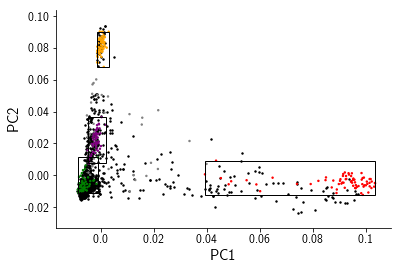

In [17]:
# Plot PCA to get boundaries
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}
refdata = data[(data["Population"].apply(lambda x: str(x) != "nan"))]
refdata["color"] = refdata.apply(lambda x: POPCOLORS.get(x["Superpop"],"gray"), 1)
ssc = data[(data["Population"].apply(lambda x: str(x) == "nan"))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ssc["pc1"], ssc["pc2"], color="black", s=2);
ax.scatter(refdata["pc1"], refdata["pc2"], color=list(refdata["color"]), s=2);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15);

# Get Europeans boundaries
#for popname in set(refdata["Superpop"]):
for popname in ["EAS","AFR","SAS","EUR"]:
    pop = refdata[refdata["Superpop"]==popname]
    max_pc1 = max(pop["pc1"])
    min_pc1 = min(pop["pc1"])
    max_pc2 = max(pop["pc2"])
    min_pc2 = min(pop["pc2"])
    ssc_pop = ssc[(ssc["pc1"]>=min_pc1) & (ssc["pc1"]<=max_pc1) &
                 (ssc["pc2"]>=min_pc2) & (ssc["pc2"]<=max_pc2)]
    ssc.ix[ssc["sample"].apply(lambda x: x in ssc_pop["sample"].values),"Superpop"] = popname
    ax.add_patch(
        patches.Rectangle(
        (min_pc1, min_pc2),
        max_pc1-min_pc1,
        max_pc2-min_pc2,
        fill=False
        ))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(["%.2f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "%s_POPPCA.pdf"%PREFIX))

def concat(x):
    items = list(set([str(item) for item in x if str(item) != "nan"]))
    if len(items)==0 or len(items)> 1: return "Admixed"
    else: return ",".join(items)
ssc_family = ssc.groupby("family", as_index=False).agg({"Superpop": concat})
ssc_family.to_csv("../../metadata/ssc_family_populations.tab", sep="\t", index=False)
ssc_family["family"] = ssc_family["family"].apply(int)

# SuppFig B: Mutation rate by population

In [34]:
data = {}
data["ALL"] = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2.tab"), sep="\t")
for period in range(1, 7):
    data[period] = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2_period%s.tab"%period), sep="\t")

families = [] 
expected_u = []
observed_u = []
expected_rates_u = []
observed_rates_u = []
periods = []
totals = []

allfams = list(set(data["ALL"]["family"]))
for period in data.keys():
    bychild = data[period]
    bychild["prior_sum_scaled"] = bychild["prior_sum"]
    for f in allfams:
        try:
            exp_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==0)]["prior_sum_scaled"].values[0]
        except: exp_u = 0
        try:
            obs_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==PTHRESH)]["numutations"].values[0]
        except: obs_u = 0
        total = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==0)]["numutations"].values[0]
        exp_r_u = exp_u*1.0/total
        obs_r_u = obs_u*1.0/total
        totals.append(total)
        expected_u.append(exp_u)
        observed_u.append(obs_u)
        expected_rates_u.append(exp_r_u)
        observed_rates_u.append(obs_r_u)
        families.append(f)
        periods.append(period)

pdata = pd.DataFrame({
    "family": families,
    "exp_u": expected_u,
    "obs_u": observed_u,
    "exp_rate_u": expected_rates_u,
    "obs_rate_u": observed_rates_u,
    "period": periods,
    "totals": totals,
})
pdata = pd.merge(pdata, ssc_family, on="family")
pdata = pd.merge(pdata, age, on="family")
poplabels = {
    "EUR": "1-EUR",
    "EAS": "2-EAS",
    "SAS": "3-SAS",
    "AFR": "4-AFR",
    "Admixed": "5-Admixed"
}
pdata["SuperpopLabel"] = pdata["Superpop"].apply(lambda x: poplabels[x])

In [66]:
def Adjust(targetvals, covar):
    xd = list(covar)
    yd = list(targetvals)
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    pred = [slope*item + intercept for item in xd]
    return [yd[i]-pred[i] for i in range(len(yd))]

def GetLabel(x):
    return (x.values[0])

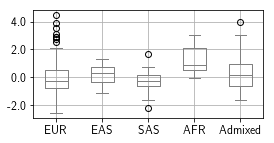

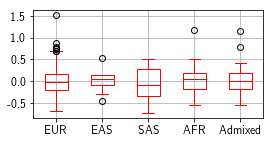

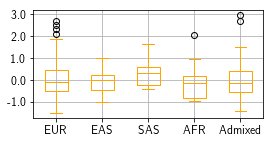

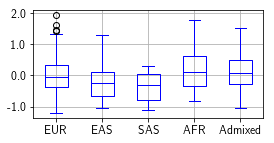

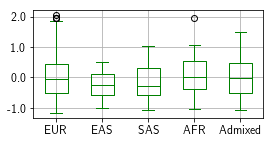

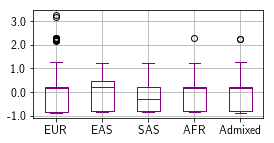

In [115]:
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "orange",
    4: "blue",
    5: "green",
    6: "purple"
}
for period in range(1, 7):
    df = pdata[(pdata["period"]==period)]
    df = df.groupby("family", as_index=False).agg({"totals": sum, "obs_u": sum, "exp_u": sum,
                                               "SuperpopLabel": GetLabel, "Superpop": GetLabel,
                                              "Father_age_at_birth": GetLabel})
    df["rate"] = df.apply(lambda x: (x["obs_u"]*1.0/x["totals"])/(x["exp_u"]/x["totals"]), 1) # Normalize by expected rate
    df["adjrate"] = Adjust(df["rate"].values, df["Father_age_at_birth"].values)

    fig = plt.figure()
    fig.set_size_inches((4, 2))
    ax = fig.add_subplot(111)
    color = PCOLORS[period]
    boxprops = dict(linestyle='-', linewidth=1)
    medianprops = dict(linestyle='-', linewidth=1)
    bp = df.boxplot(by="SuperpopLabel", column="adjrate", ax=ax, boxprops=boxprops,
                medianprops=medianprops, return_type='dict')
    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['caps']] for key in bp.keys()]

    ax.set_title("");
    fig.suptitle("")
    ax.set_xlabel("");
    #ax.set_ylabel("Adjusted mutation rate", size=15)
    #ax.set_xlabel("Population group", size=15)
    ax.set_xticklabels(["EUR","EAS","SAS","AFR","Admixed"], size=12)
    ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

    rate_eur = df[df["Superpop"]=="EUR"]["adjrate"]
    rate_afr = df[df["Superpop"]=="AFR"]["adjrate"]
    rate_asia = df[df["Superpop"].apply(lambda x: x in ["SAS","EAS"])]["adjrate"]
    #print("EUR vs. AFR"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_afr)))
    #print("EUR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_asia)))
    #print("AFR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_afr, rate_asia)))
    fig.savefig(os.path.join(OUTPATH, "%s_poprate_period%s.pdf"%(PREFIX, period)))